In [153]:
import pandas as pd
import numpy as np

%run ../src/preprocessing/initial_prep.py




In [154]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion,Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn import set_config
set_config(display ="diagram")

import matplotlib.pyplot as plt
%matplotlib inline



In [155]:
def age_categories (age, age_groups=[0, 16, 21, 24, 35, 55, 70, 80, 100]):
    bins=[x for x in age_groups]
    age_group=pd.cut(x=age, bins=bins)
    return age_group

def car_age_categories (year, age_groups=[0,3,8,15,25]):    
    latest=date.today().year
    oldest=1900
    
    bins=[x for x in age_groups]
    bins=np.sort(np.abs(np.array(bins)-latest))
    bins=np.insert(bins, 0, oldest)

    car_age_cat=pd.cut(x=[year], bins=bins)
    return car_age_cat

def select_license_class(dl_code):
    dl = 'Other'
    if dl_code in ["A","B","C","AM","BM","CD","S"]:
        dl='Commercial'
    elif dl_code in ('DM','D'):
        dl='Regular'
    return dl

def explore_cat_vars(df, n):
    col_counts=pd.DataFrame(df.nunique(),).reset_index()
    col_counts.columns=(["Col_Name", "Count"])
    for col in col_counts[col_counts['Count'] < n]['Col_Name']:
        print('--------------------------------------')
        print(col)
        print('--------------------------------------')
        print(df[col].value_counts())
    print("=================================================================================================")
    print(col_counts[col_counts['Count'] >= n])

In [156]:
#explore_cat_vars(train_df, 42)

def get_unknown (df):
    new_df=df.copy()
    info=[]
    total = df.shape[0]
    for col in df.columns:
        unknown_n=round((df[col]=='UNKNOWN').sum()/total*100,2)
        not_na = round(df[col].isna().sum()/total*100,2)
        na_and_unknown=unknown_n+not_na
        
        if unknown_n > 0 and na_and_unknown < 40 :
            new_df=df[df[col]!='UNKNOWN']
    return new_df


filtered_train=get_unknown(train_df)


In [157]:

df=train_df.sample(10000)
#test=get_unknown(test_df).sample(8000)


In [158]:
col=['GUILTY','DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','ROAD_DEFECT','POSTED_SPEED_LIMIT','VEHICLE_DEFECT',
            'ALIGNMENT', 'LIGHTING_CONDITION', 'WEATHER_CONDITION','SEX','DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 
            'PHYSICAL_CONDITION', 'MANEUVER','NUM_PASSENGERS',  'DRIVER_VISION', 'VEHICLE_YEAR', 'VEHICLE_AGE', ]

col=['GUILTY','DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','VEHICLE_DEFECT',
             'DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 'VEHICLE_AGE', 'NUM_PASSENGERS', 'AIRBAG_DEPLOYED',
            'PHYSICAL_CONDITION', 'MANEUVER',  'DRIVER_VISION',  'ALIGNMENT'  ]

df=df[col].copy()



In [159]:

#df.dropna(subset=['AGE_GROUP','DRIVERS_LICENSE_CLASS'], inplace=True)

y_train = df['GUILTY']
X_train = df.drop(columns = 'GUILTY')



In [160]:
#ordinal_columns = ['DRIVERS_LICENSE_CLASS']
numeric_columns = ['NUM_PASSENGERS']
nominal_columns = ['DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','VEHICLE_DEFECT',
             'DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 'VEHICLE_AGE', 'AIRBAG_DEPLOYED',
            'PHYSICAL_CONDITION', 'MANEUVER',  'DRIVER_VISION',  'ALIGNMENT']



In [161]:
from sklearn.pipeline import FeatureUnion

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_columns)),
        ('imputer', SimpleImputer(strategy = 'constant', fill_value=0)),
        ('std_scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(nominal_columns)),
        ('imputer', SimpleImputer(strategy = 'constant', fill_value='NA')),
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
    ])


fu = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


X_train_transformed = fu.fit_transform(X_train)
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 68189 to 140357
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   DEVICE_CONDITION       10000 non-null  object  
 1   FIRST_CRASH_TYPE       10000 non-null  object  
 2   FIRST_CONTACT_POINT    10000 non-null  object  
 3   TRAFFICWAY_TYPE        10000 non-null  object  
 4   ROADWAY_SURFACE_COND   10000 non-null  object  
 5   VEHICLE_DEFECT         10000 non-null  object  
 6   DRIVERS_LICENSE_CLASS  10000 non-null  object  
 7   AGE_GROUP              9996 non-null   category
 8   VEHICLE_AGE            9983 non-null   category
 9   NUM_PASSENGERS         2619 non-null   float64 
 10  AIRBAG_DEPLOYED        10000 non-null  object  
 11  PHYSICAL_CONDITION     10000 non-null  object  
 12  MANEUVER               10000 non-null  object  
 13  DRIVER_VISION          10000 non-null  object  
 14  ALIGNMENT              10000 non-

In [162]:
columns=fu.transformer_list[1][1][2].get_feature_names_out()
columns=np.insert(columns, 0, 'Intercept')
transformed_df=pd.DataFrame(X_train_transformed, columns=columns)
transformed_df

#transformed_df.info(verbose=True, show_counts=True)






,Intercept,x0_FUNCTIONING IMPROPERLY,x0_FUNCTIONING PROPERLY,x0_MISSING,x0_NO CONTROLS,x0_NOT FUNCTIONING,x0_OTHER,x0_UNKNOWN,x0_WORN REFLECTIVE MATERIAL,x1_ANGLE,x1_ANIMAL,x1_FIXED OBJECT,x1_HEAD ON,x1_OTHER NONCOLLISION,x1_OTHER OBJECT,x1_OVERTURNED,x1_PARKED MOTOR VEHICLE,x1_PEDALCYCLIST,x1_PEDESTRIAN,x1_REAR END,x1_REAR TO FRONT,x1_REAR TO SIDE,x1_SIDESWIPE OPPOSITE DIRECTION,x1_SIDESWIPE SAME DIRECTION,x1_TURNING,x2_FRONT,x2_FRONT-LEFT,x2_FRONT-RIGHT,x2_NONE,x2_OTHER,x2_REAR,x2_REAR-LEFT,x2_REAR-RIGHT,x2_ROOF,x2_SIDE-LEFT,x2_SIDE-RIGHT,x2_TOTAL (ALL AREAS),x2_UNDER CARRIAGE,x2_UNKNOWN,x3_ALLEY,...,x11_DIVERGING,x11_DRIVING WRONG WAY,x11_ENTER FROM DRIVE/ALLEY,x11_ENTERING TRAFFIC LANE FROM PARKING,x11_LEAVING TRAFFIC LANE TO PARK,x11_MERGING,x11_NEGOTIATING A CURVE,x11_OTHER,x11_PARKED,x11_PASSING/OVERTAKING,x11_SKIDDING/CONTROL LOSS,x11_SLOW/STOP - LEFT TURN,x11_SLOW/STOP - LOAD/UNLOAD,x11_SLOW/STOP - RIGHT TURN,x11_SLOW/STOP IN TRAFFIC,x11_STARTING IN TRAFFIC,x11_STRAIGHT AHEAD,x11_TURNING LEFT,x11_TURNING ON RED,x11_TURNING RIGHT,x11_U-TURN,x11_UNKNOWN/NA,x12_BLINDED - HEADLIGHTS,x12_BLINDED - SUNLIGHT,x12_BUILDINGS,x12_HILLCREST,x12_MOVING VEHICLES,x12_NOT OBSCURED,x12_OTHER,x12_PARKED VEHICLES,x12_SIGNBOARD,"x12_TREES, PLANTS",x12_UNKNOWN,x12_WINDSHIELD (WATER/ICE),x13_CURVE ON GRADE,x13_CURVE ON HILLCREST,"x13_CURVE, LEVEL",x13_STRAIGHT AND LEVEL,x13_STRAIGHT ON GRADE,x13_STRAIGHT ON HILLCREST
0,-0.468963,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.468963,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.882907,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.468963,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.468963,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.468963,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9996,-0.468963,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [163]:
baseline_pipe = Pipeline([ ('fu', fu),
                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
#                          ('standardscale', StandardScaler()),
                          ('model',LogisticRegression(max_iter = 10000, solver = 'newton-cg'))])
baseline_pipe

Pipeline(steps=[('fu',
                 FeatureUnion(transformer_list=[('num_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  DataFrameSelector(attribute_names=['NUM_PASSENGERS'])),
                                                                 ('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('std_scaler',
                                                                  StandardScaler())])),
                                                ('cat_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  DataFrameSelector(attribute_names=['DEVICE_CONDITION',
                                                                                                     'FIRS...
                                                                                                     'AIRBAG_DEPLOYED',
                                                                                                     'PHYSICAL_CONDITION',
                                                                                                     'MANEUVER',
                                                                                                     'DRIVER_VISION',
                                                                                                     'ALIGNMENT'])),
                                                                 ('imputer',
                                                                  SimpleImputer(fill_value='NA',
                                                                                strategy='constant')),
                                                                 ('cat_encoder',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                sparse=False))]))])),
                ('onehotenc',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse=False)),
                ('model',
                 LogisticRegression(max_iter=10000, solver='newton-cg'))])

In [126]:
baseline_pipe.fit(X_train, y_train)

Pipeline(steps=[('fu',
                 FeatureUnion(transformer_list=[('num_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  DataFrameSelector(attribute_names=['NUM_PASSENGERS'])),
                                                                 ('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('std_scaler',
                                                                  StandardScaler())])),
                                                ('cat_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  DataFrameSelector(attribute_names=['DEVICE_CONDITION',
                                                                                                     'FIRS...
                                                                                                     'VEHICLE_AGE',
                                                                                                     'AIRBAG_DEPLOYED',
                                                                                                     'PHYSICAL_CONDITION',
                                                                                                     'MANEUVER',
                                                                                                     'DRIVER_VISION',
                                                                                                     'ALIGNMENT'])),
                                                                 ('cat_encoder',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                sparse=False)),
                                                                 ('carAgeIterImputer',
                                                                  IterativeImputer())]))])),
                ('onehotenc',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse=False)),
                ('model',
                 LogisticRegression(max_iter=10000, solver='newton-cg'))])

In [127]:
#y_pred_test = baseline_pipe.predict(X_test)
y_pred_train = baseline_pipe.predict(X_train)

In [128]:
print('Precision : ', precision_score(y_train, y_pred_train, pos_label="NO"),
      '\n Recall score: ', recall_score(y_train, y_pred_train, pos_label="NO"),
      '\n Accuracy Score :', accuracy_score(y_train, y_pred_train,))
print('------------')
#print('Precision : ', precision_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Recall score: ', recall_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Score :', accuracy_score(y_test, y_pred_test,))

Precision :  0.7416632358995472 
 Recall score:  0.7547130289065773 
 Accuracy Score : 0.7574
------------


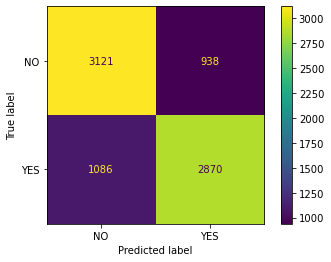

In [1274]:

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)

In [1275]:
print(baseline_tree_pipe.steps)

[('preproc', ColumnTransformer(remainder='passthrough',
                  transformers=[('dlImputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['DRIVERS_LICENSE_CLASS'])])), ('onehotenc', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)), ('standardscale', StandardScaler()), ('model', DecisionTreeClassifier(max_depth=9, min_samples_leaf=12, min_samples_split=6))]


In [1276]:
#pipe_grid = {'model__max_depth': [ 7,8, 9, 10,11],
#            'model__min_samples_split':[6,7,8,9],'model__min_samples_leaf':[11,12,13]}

pipe_grid = {'model__criterion': ['gini', 'entropy']}



gs_pipe = GridSearchCV(estimator=baseline_tree_pipe, 
                       param_grid=pipe_grid, cv=10)

In [1281]:
gs_pipe.fit(X_train, y_train)

C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [6, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [10] during trans

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('dlImputer',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         ['DRIVERS_LICENSE_CLASS'])])),
                                       ('onehotenc',
                                        OneHotEncoder(drop='first',
                                                      handle_unknown='ignore',
                                                      sparse=False)),
                                       ('standardscale', StandardScaler()),
                                       ('model',
                                        DecisionTreeClassifier(max_depth=9,
                                                               min_samples_leaf=12,
                                                               min_samples_split=6))]),
             param_grid={'model__criterion': ['gini', 'entropy']})

In [1282]:
#gs_pipe.best_estimator_.score(X_test, y_test)
# pd.Series(gs_pipe.estimator.get_params().items())

In [1283]:
y_pred_train=gs_pipe.predict(X_train)
#y_pred_test=gs_pipe.predict(X_test)

In [1284]:
print('Precision : ', precision_score(y_train, y_pred_train, pos_label="NO"),
      '\n Recall score: ', recall_score(y_train, y_pred_train, pos_label="NO"),
      '\n Score :', accuracy_score(y_train, y_pred_train,))
print('------------')
#print('Precision : ', precision_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Recall score: ', recall_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Score :', accuracy_score(y_test, y_pred_test,))

Precision :  0.7422990232907588 
 Recall score:  0.7302291204730229 
 Score : 0.7349968808484092
------------


In [1244]:
pipe_grid = {'model__solver': ['newton-cg']}

gs_pipe = GridSearchCV(estimator=baseline_pipe, param_grid=pipe_grid, cv=5)

In [1245]:
#pd.Series(gs_pipe.estimator.get_params().items())

In [1246]:
gs_pipe.fit(X_train, y_train)

C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotenc',
                                        OneHotEncoder(drop='first',
                                                      handle_unknown='ignore',
                                                      sparse=False)),
                                       ('standardscale', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           solver='newton-cg'))]),
             param_grid={'model__solver': ['newton-cg']})

In [1253]:
gs_pipe.best_params_

{'model__solver': 'newton-cg'}

In [1251]:
y_pred_train=gs_pipe.predict(X_train)
#y_pred_test=gs_pipe.predict(X_test)

In [1252]:
print('Precision : ', precision_score(y_train, y_pred_train, pos_label="NO"),
      '\n Recall score: ', recall_score(y_train, y_pred_train, pos_label="NO"),
      '\n Score :', accuracy_score(y_train, y_pred_train,))
print('------------')
#print('Precision : ', precision_score(y_test, y_pred_test, pos_label="NO"),
#     '\n Recall score: ', recall_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Score :', accuracy_score(y_test, y_pred_test,))

Precision :  0.7241379310344828 
 Recall score:  0.7267652804912085 
 Score : 0.753625
------------


In [1229]:
baseline_tree_pipe = Pipeline([('preproc', preproc),
                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
                          ('standardscale', StandardScaler()),
                          ('model',DecisionTreeClassifier(splitter='best', max_depth=9,
                                                                  min_samples_split=6, min_samples_leaf=12))
                              ])

In [46]:
baseline_tree_pipe.fit(X_train, y_train)

NameError: name 'baseline_tree_pipe' is not defined

In [1231]:
#y_pred_test = baseline_tree_pipe.predict(X_test)
y_pred_train = baseline_tree_pipe.predict(X_train)

In [1232]:
print('Precision : ', precision_score(y_train, y_pred_train, pos_label="NO"),
      '\n Recall score: ', recall_score(y_train, y_pred_train, pos_label="NO"),
      '\n Score :', accuracy_score(y_train, y_pred_train,))
print('------------')
#print('Precision : ', precision_score(y_test, y_pred_test, pos_label="NO"),
##      '\n Recall score: ', recall_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Score :', accuracy_score(y_test, y_pred_test,))

Precision :  0.7067069818581638 
 Recall score:  0.7175551214066425 
 Score : 0.740125
------------
